In [1]:
import gravity
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.ndimage as ndimage
import scipy.optimize as sciopt
import sys
if '..' not in sys.path: sys.path.append('..'); sys.path.append('../external')

from f_ring_util.f_ring import (add_hover,
                                read_ew_stats)


LONG_RES = 0.02  # deg/pixel
RAD_RES  = 5     # km/pixel
RADIAL_STEP = 5  # km per CSV column

F_PROM_BEAT = 3.2619  # Longitudes between Prometheus/F ring core interactions
F_RING_N = 581.964    # deg/day
F_RING_A = 140221.3   # km
F_RING_E = 0.00235
F_RING_I = 0.00643    # deg
F_RING_SIN_I = np.sin(np.radians(F_RING_I))

# The gravity module's idea of the mean motion of the F ring core isn't precisely the same
# as that found through measurement
F_RING_N_FUDGE = F_RING_N / (np.degrees(gravity.SATURN.n(F_RING_A, F_RING_E, F_RING_SIN_I))*86400)

#%matplotlib notebook

In [2]:
obsdata = read_ew_stats('../data_files/ISS_093RF_FMOVIE003_PRIME-cs.csv')
# Restrict longitudes to just the last 4 channel-streamers
obsdata = obsdata[obsdata['Min Long'] > 316]

** SUMMARY STATISTICS - ../data_files/ISS_093RF_FMOVIE003_PRIME-cs.csv **
Unique observation names: 1
Total slices: 1399
Starting date: 2008-11-14 19:49:51
Ending date: 2008-11-14 21:00:47
Time span: 0 days 01:10:56


In [3]:
def interp_ypts(offset, stretch, ypts, fill=None):
    # Interpolate a profile at a new set of longitudes stretched by "stretch" and offset by "offset".
    
    # The range of longitudes for the original data; we don't care about the 
    # absolute values, only the step size
    old_long = np.arange(len(ypts)) * LONG_RES

    # Find the new longitudes to sample at based on stretch and offset
    # We want to stretch such that the higher longitudes stay in place and the lower
    # longitudes shrink or enlarge
    new_long = (old_long - old_long[-1] - offset) * stretch + old_long[-1]
    
    # Compute the new data using interpolation
    # If we try to interpolate with data we don't have, set it to "fill".
    new_ypts = np.interp(new_long, old_long, ypts, left=fill, right=fill)

    return new_ypts

def fit_func(params, ypts1, ypts0):
    # Helper function for optimization. Given optimization parameters "params" (offset, stretch),
    # compute the interpolated data, remove bad points, and return the RMS.
    
    assert len(ypts1) == len(ypts0)
    
    # offset is specified in degrees
    # stretch is specified as a factor;
    #    1 means leave the original ypts1 alone
    #   >1 means shrink the data to be narrower
    #   <1 means grow the data to be wider
    offset, stretch = params
    
    new_ypts0 = interp_ypts(offset, stretch, ypts0, fill=1e38)
    # If the interpolation made the data set shorter, we don't want to compare
    # useless data
    new_ypts1 = ypts1[new_ypts0 != 1e38]
    new_ypts0 = new_ypts0[new_ypts0 != 1e38]
        
    return np.sum((new_ypts1-new_ypts0)**2)

def align_profiles(obsdata, a1, a0, bounds_offset=None, bounds_stretch=None, verbose=True):
    # Given a DataFrame and two semi-major axes (a1>a0), figure out the stretch and offset
    # required to align them.
    
    # Find the mean motion at the two semi-major axes, adjusted for error
    n0 = np.degrees(gravity.SATURN.n(a0, F_RING_E, F_RING_SIN_I))*86400 * F_RING_N_FUDGE
    n1 = np.degrees(gravity.SATURN.n(a1, F_RING_E, F_RING_SIN_I))*86400 * F_RING_N_FUDGE
    # Compute how much a particle moves at a0 during one orbit at a1 and derive the slope in
    # deg/km
    t1 = 360/n1 # Time for one orbit at a1
    deg0 = t1*n0 # Longitude distance at a0 during time of one orbit at a1
    expected_slope = (deg0-360)/(a1-a0) # deg/km

    # Give a little wiggle room for the slope to be found during optimization
    expected_slope_min = expected_slope * .9
    expected_slope_max = expected_slope * 1.1
    if verbose:
        print('Expected slope', expected_slope)

    # Compute the stretch from the slope
    expected_stretch = (F_PROM_BEAT - expected_slope * (a1-a0)) / F_PROM_BEAT
    expected_stretch_max = (F_PROM_BEAT - expected_slope_min * (a1-a0)) / F_PROM_BEAT
    expected_stretch_min = (F_PROM_BEAT - expected_slope_max * (a1-a0)) / F_PROM_BEAT
    if verbose:
        print('Expected stretch', expected_stretch)
    
    if bounds_stretch is None:
        bounds_stretch = (expected_stretch_min, expected_stretch_max)
        
    if bounds_offset is None:
        bounds_offset = (-3., 3.)
        
    ypts1 = obsdata[f'Normal EW{a1} Mean'].to_numpy()
    ypts0 = obsdata[f'Normal EW{a0} Mean'].to_numpy()

    # First normalize each to its mean so they're centered on zero
#     norm_ypts1 = ypts1 - np.mean(ypts1)
#     norm_ypts0 = ypts0 - np.mean(ypts0)
    # Make the values much larger so the least_squares function looks for a precise answer
#     norm_ypts1 *= 1e8
#     norm_ypts0 *= 1e8
#     ypts1 = norm_ypts1 = ndimage.sobel(ypts1, mode='nearest')
#     ypts0 = norm_ypts0 = ndimage.sobel(ypts0, mode='nearest')

    # Apply a small median filter to reduce the noise in the profiles
    ypts1 = norm_ypts1 = ndimage.median_filter(ypts1, size=5, mode='nearest')
    ypts0 = norm_ypts0 = ndimage.median_filter(ypts0, size=5, mode='nearest')
    
    # Initial guess is no offset and mean stretch
    initial_guess = (0., np.mean(bounds_stretch))
    bounds = ((bounds_offset[0], bounds_stretch[0]),
              (bounds_offset[1], bounds_stretch[1]))
    opt = sciopt.least_squares(fit_func, 
                               initial_guess,
                               bounds=bounds,
                               args=(norm_ypts1, norm_ypts0))
    offset = opt['x'][0]
    stretch = opt['x'][1]
    new_ypts0 = interp_ypts(offset, stretch, ypts0)
    
    # Reverse compute the slope from the stretch
    slope = (1-stretch)*F_PROM_BEAT / (a1-a0)
    slope_ratio = slope / expected_slope

    if verbose:
        print('Offset', offset)
        print('Stretch', stretch)
        print('Slope', slope)
        print('Slope ratio', slope_ratio)

    metadata = {
        'expected_slope': expected_slope,
        'expected_stretch': expected_stretch,
        'offset': offset,
        'stretch': stretch,
        'slope': slope,
        'slope_ratio': slope_ratio,
        'ypts1': ypts1,
        'ypts0': ypts0,
        'new_ypts0': new_ypts0
    }
    return metadata

def plot_channels(obsdata, metadata):
    ypts1 = metadata['ypts1']
    ypts0 = metadata['ypts0']
    new_ypts0 = metadata['new_ypts0']
    longitudes = obsdata['Min Long']
    plt.figure()
    plt.plot(longitudes, ypts1-np.mean(ypts1), lw=1, color='blue', label='Primary')
    plt.plot(longitudes, ypts0-np.mean(ypts0), lw=1, color='orange', label='Secondary Orig')
    plt.plot(longitudes, new_ypts0-np.mean(new_ypts0), lw=1, color='red', label='Secondary Opt')
    plt.legend()
    plt.show()

Expected slope 0.0038645285931011132
Expected stretch 0.9940762613919785
Offset 0.018126163069381578
Stretch 0.9940928567180136
Slope 0.003853702134302276
Slope ratio 0.9971985046719115


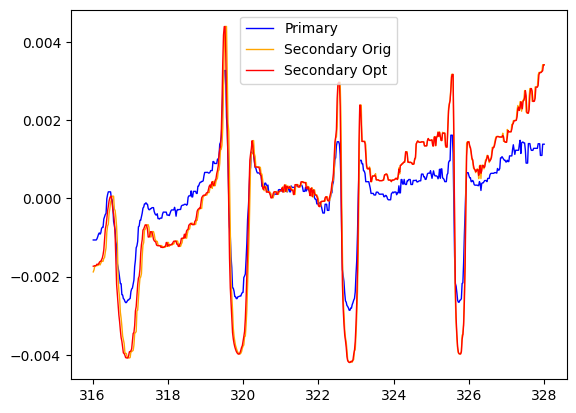

In [4]:
metadata = align_profiles(obsdata, 140170, 140165)
plot_channels(obsdata, metadata)

Expected slope 0.0038673381529595948
Expected stretch 0.9644317285665447
Offset -0.06328114459227832
Stretch 0.9608768726908152
Slope 0.00425385763232766
Slope ratio 1.0999445779191224


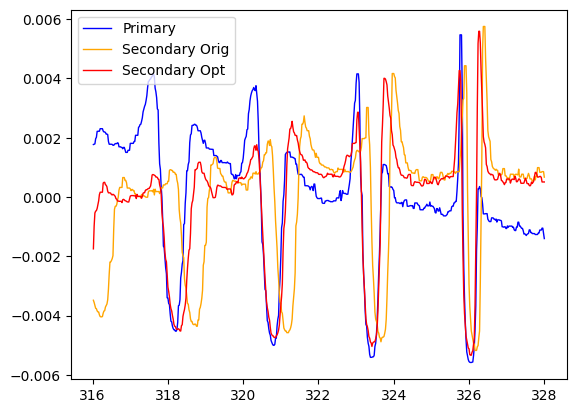

In [5]:
metadata = align_profiles(obsdata, 140100, 140070)
plot_channels(obsdata, metadata)

Expected slope 0.003870085617984387
Expected stretch 0.9940677433122039
Offset 0.0
Stretch 0.994067743312204
Slope 0.0038700856179843257
Slope ratio 0.9999999999999842


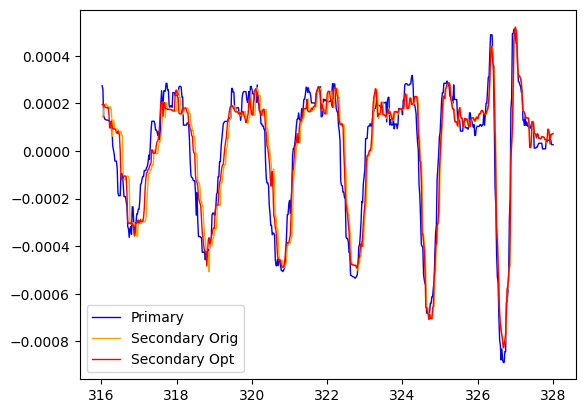

In [6]:
metadata = align_profiles(obsdata, 139970, 139965)
plot_channels(obsdata, metadata)

<Figure size 640x480 with 0 Axes>

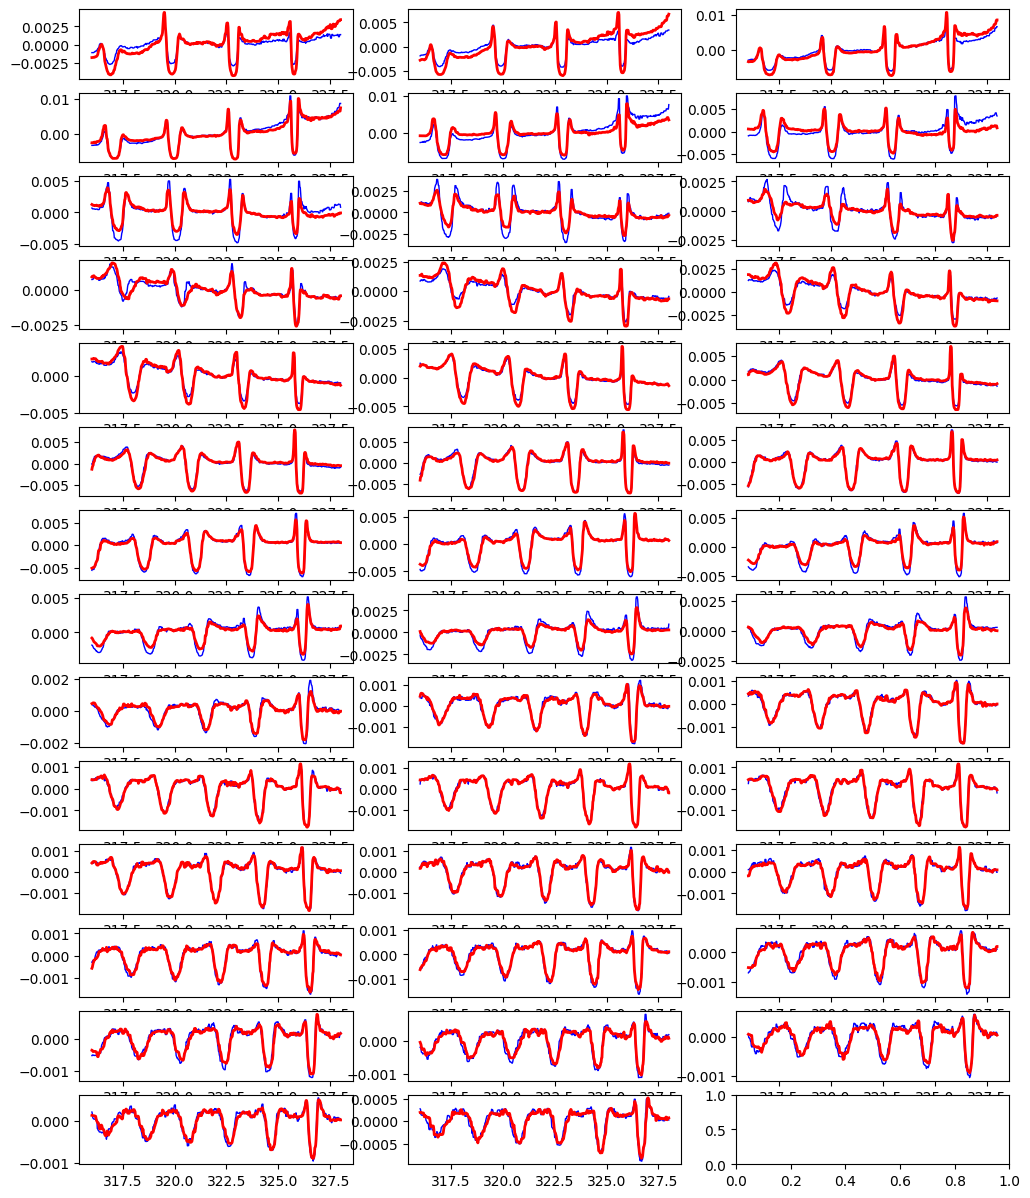

In [7]:
max_a = 140170
min_a = 139970
plt.figure()
fix, axs = plt.subplots(int(np.ceil((max_a-min_a)/5/3)), 3, figsize=(12,15))
slope_ratios = []
rs = []
plt_num = 0
for r in range(max_a, min_a-1, -5):
    metadata = align_profiles(obsdata, r, r-5, verbose=False)
    rs.append(r)
    slope_ratios.append(metadata['slope_ratio'])
    ax = axs[int(plt_num/3), plt_num%3]
    ypts1 = metadata['ypts1']
    ypts0 = metadata['ypts0']
    new_ypts0 = metadata['new_ypts0']
    longitudes = obsdata['Min Long']
    ax.plot(longitudes, ypts1-np.mean(ypts1), lw=1, color='blue')
#     ax.plot(longitudes, ypts0-np.mean(ypts0), lw=1, color='green')
    ax.plot(longitudes, new_ypts0-np.mean(new_ypts0), lw=2, color='red')
    plt_num += 1

[0.9971985046719115,
 0.9980854083415136,
 0.9695770915830042,
 0.9739418266971425,
 0.9984668927773034,
 0.9619437525166351,
 0.9023314164601103,
 0.9990922894386547,
 1.0064341916045947,
 1.0152076431381256,
 1.0131007956152778,
 1.0076694681935403,
 1.003092510535903,
 1.002402122694453,
 1.0032121936854201,
 1.0062065949132781,
 1.0110707839095339,
 1.0790262137021045,
 1.07107778403204,
 1.0624037659026098,
 1.0169329743545221,
 1.00561530352804,
 1.0078671135038806,
 1.0042018199057556,
 1.0080657407365003,
 1.005926484406549,
 1.0045117588382324,
 1.0037983110660316,
 1.0029953929320101,
 0.9999999999999852,
 1.0040096799740128,
 1.0012112382540053,
 1.002494634205772,
 1.002309717226424,
 1.0029118891680653,
 1.003669076639839,
 0.9999999999999947,
 1.000000000000004,
 0.9999999999999989,
 0.9999999999999922,
 0.9999999999999842]

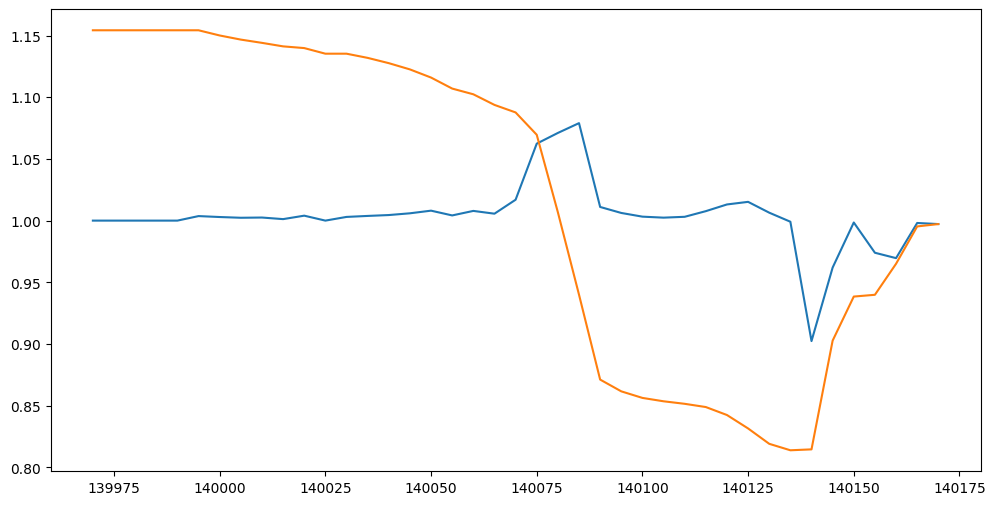

In [14]:
plt.figure(figsize=(12,6))
plt.plot(rs, slope_ratios)
plt.plot(rs, np.cumprod(slope_ratios))
slope_ratios

Expected slope 0.0038712895177573613
Expected stretch 0.7626359166278941
Offset -0.15965049070552428
Stretch 0.6712127567538801
Slope 0.005362355543722591
Slope ratio 1.3851600401173314


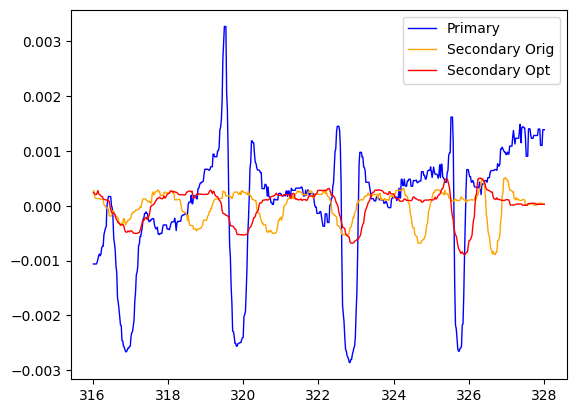

In [15]:
metadata = align_profiles(obsdata, max_a, min_a, bounds_offset=(-4,0), bounds_stretch=(0.5, 0.76))
plot_channels(obsdata, metadata)